In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# string.punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from numpy.random import seed

import tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor, reorder, to_dense

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pd.set_option('display.max_colwidth', None)
df_sa = pd.read_csv('sentiment_analysis.csv',engine='python', error_bad_lines=False)
df_ce = pd.read_csv('Canadian_elections_2021.csv',engine='python', error_bad_lines=False)

## 1. Data Cleaning

In [ ]:
## Remove emoji
df_sa = df_sa.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df_ce = df_ce.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [ ]:
stop_words = stopwords.words('english')
sno = nltk.stem.SnowballStemmer('english')
remove_list = ['against','no','not']
stop_words = [ elem for elem in stop_words if elem not in remove_list]
stop_words.append('u')
stop_words.append('amp')
print("The length of stopwords list is:", len(stop_words))

The length of stopwords list is: 178


In [ ]:
def data_cleaning(text):
    # Remove URLS
    text = re.sub(r" http\S+", "", text)
    # Remove the 'Reply To' part
    text = re.sub("RT @[A-Za-z0-9_]+: ","", text)
    # Lowercases
    text = text.lower()
    # Replace all "'t" to not
    text = re.sub(r"\'t", "not", text)
    
    return text 

def remove_pun(text):
    # Remove punctuations
    text = re.sub(r"[^\w\s]", ' ', text)
    
    return text

def remove_stopwords(text):
    # Remove Stopwords
    word_tokens = word_tokenize(text) 
    
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    
    return text

In [ ]:
df_sa['text_cleaned'] = df_sa['text'].apply(lambda x: data_cleaning(x))
df_sa['text_cleaned'] = df_sa['text_cleaned'].apply(lambda x: remove_pun(x))
df_sa['text_cleaned'] = df_sa['text_cleaned'].apply(lambda x: remove_stopwords(x))
df_sa.head(10)

,ID,text,label,text_cleaned
0,7.68098e+17,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,1,josh jenkins looking forward tab breeders crown super sunday
1,7.68098e+17,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o,1,congratulations pakistan becoming no1testteam world against odds ji_pakzindabadrallies
2,7.68098e+17,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendozas surprise thanksgiving party she threw for her fans! https://t.co/oX",1,september yesmag taking maine mendozas surprise thanksgiving party threw fans
3,7.68098e+17,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/",1,newly painted walls thanks million custodial painters summer great job ladies ec_proud
4,7.68098e+17,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,1,excited announce july 2017 feschotte lab relocating cornell mbg
5,7.68098e+17,RT @SH4WNSMILE: -Who is excited for illuminate !? -.... https://t.co/AKnIVEGUOe,1,excited illuminate
6,7.68098e+17,RT @KendallHuntRPD: The #firstdayofschool for students &amp; teachers. Good luck and have a Successful 2016-17 School Year #EducationMatters ht,1,firstdayofschool students teachers good luck successful 2016 17 school year educationmatters ht
7,7.68098e+17,RT @BantySrkian: #SRK and kajol in the making of DDLJ song .. Both are greatest ever https://t.co/Aa7fAvvtNE,1,srk kajol making ddlj song greatest ever
8,7.68098e+17,RT @GayHopper_com: I'm happy! https://t.co/fKXbN3Zhtd,1,happy
9,7.68098e+17,"RT @StarCinema: Kathryn, Daniel share memorable experience in Barcelona SEE INTERVIEW HERE: https://t.co/Vub69JTdKL https://t.co/NntyQWs7To",1,kathryn daniel share memorable experience barcelona see interview


In [ ]:
df_ce['text_cleaned'] = df_ce['text'].apply(lambda x: data_cleaning(x))
df_ce['text_cleaned'] = df_ce['text_cleaned'].apply(lambda x: remove_pun(x))
df_ce['text_cleaned'] = df_ce['text_cleaned'].apply(lambda x: remove_stopwords(x))
df_ce.head(10)

,text,sentiment,negative_reason,text_cleaned
0,"The Canadian election is a power grab by PM Trudeau, yes -- to take it away from the opposition leaders who have chosen obstruction (20 non-confidence motions) and disinformation in the middle of a worldwide pandemic. Yes, no one wanted a vote; the opposition antics forced it.",negative,calling election early,canadian election power grab pm trudeau yes take away opposition leaders chosen obstruction 20 non confidence motions disinformation middle worldwide pandemic yes no one wanted vote opposition antics forced
1,"I do hope Trudeau loses the Canadian election tomorrow , called a snap one thinking hed romp it.. Seems the people there dont like a Black face hypocrite, super wokist &amp; COVID restriction groupie.. Lets hope the polls are right, might make our Government think again.",negative,covid,hope trudeau loses canadian election tomorrow called snap one thinking hed romp seems people dont like black face hypocrite super wokist covid restriction groupie lets hope polls right might make government think
2,"Dear Canadians, This election is a test of how progressive we are. Whether we stand by science, womens and BIPOC rights, equality, public healthcare &amp; education, the environment. Whether we stand up against hate. We have so much to lose. Dont let us fall back. #cdnpoli #elxn44",positive,nan,dear canadians election test progressive whether stand science womens bipoc rights equality public healthcare education environment whether stand against hate much lose dont let us fall back cdnpoli elxn44
3,Canadian friends: Never forget that Trudeau had 2 more years on his mandate + called a completely unnecessary election right when vaccine mandates were being rolled out - a moment of extreme political volatility. He gambled the country all so he could be less accountable. #Elxn44,negative,calling election early,canadian friends never forget trudeau 2 years mandate called completely unnecessary election right vaccine mandates rolled moment extreme political volatility gambled country could less accountable elxn44
4,Sorry @theJagmeetSingh I have voted #NDP all my life but in this election I am fighting for my freedoms as a Canadian. I voted last Saturday for @MaxineBernier of the @peoplespca #ppc #VotePPC2021 #VoteForHumanRights #voteforfreedom #maximebernier #PurpleReign #freedom,positive,nan,sorry thejagmeetsingh voted ndp life election fighting freedoms canadian voted last saturday maxinebernier peoplespca ppc voteppc2021 voteforhumanrights voteforfreedom maximebernier purplereign freedom
5,"Vaccines &amp; guns are key this election because O'Toole has no serious plan to get all Canadians vaccinated (he can't even get his candidates vaccinated) &amp; he is playing games on guns so he can deliver for the fun lobby. But many Canadians (and for me), climate is the issue. So...",negative,covid,vaccines guns key election onotoole no serious plan get canadians vaccinated not even get candidates vaccinated playing games guns deliver fun lobby many canadians climate issue
6,"Im sorry, moderators can respond but leadership candidates cant? This debate is a farce and frankly a disservice to Canadians, and after the awful 2019 formats I hope the next election we see new moderation format. Theyve had two goes, thats enough. #elxn44 #cdnpoli",negative,others,im sorry moderators respond leadership candidates cant debate farce frankly disservice canadians awful 2019 formats hope next election see new moderation format theyve two goes thats enough elxn44 cdnpoli
7,"I have to say this. I've been skeptical and critical of mainstream Canadian journalism, but I have never seen this level of trying to choose the winner/influence the outcome of an election as I have with this one. I feel objectivity is a lost art for many in #cdnmedia. #cdnpoli",negative,others,say skeptical critical mainstream canadian journalism never seen level trying choose winner influence outcome election one feel objectivity lo

## 2. Exploratory Analysis

### Determine the Political Party

In [ ]:
# Dictionary contain hashtags show clear preference
hashtag_dict = {'Liberal': ['voteliberal','istandwithtrudeau','forwardforeveryone','voteliberalmajority',
                  'liberalmajority','teamtrudeau','trudeaumajority','vote liberal'],
                'Conservative': ['otoole4pm','otooleforpm','votecpc4canada','voteconservative',
                        'votecpc','vote cpc'],
                'NDP': ['teamjagmeet','teamsingh','votendp','readyforbetter','orangeteam',
               'ndp2021','vote ndp'],
                'PPC': ['voteppc2021','purpleregion','voteppc','maximebernierforpm','purplewave',
              'makemaxmypm','makemaxourpm','jumptoppc','vote ppc']
               }

In [ ]:
# Dictionary with keywords
keyword_dict = {'Liberal':['liberal','justin','trudeau','justintrudeau','pmjt',
                           'lpc', 'liberal party of canada'],
                'Conservative':['erin','otoole','onotoole','conservatives','conservative',
                              'erinotoole','cpc','cpc_hq'],
                'NDP':['ndp','jagmeet','jagmeetsingh','singh','thejagmeetsingh',
                       'new democratic'],
                'PPC':['maxime','bernier','maximebernier','peoplespca','ppc',
                       'peoples party of canada',
                      'pc party','jumptoppc']
                }

In [ ]:
def party_hashtag(text, dictionary1):

    text = data_cleaning(text)
    text = remove_pun(text)
    text = remove_stopwords(text)
    
    party_dict = {'Liberal':0, 'Conservative':0, 'NDP':0, 'PPC':0}
            
    party_name = None
    for key in dictionary1.keys():
        for values in dictionary1[key]:
            if values in text:
                party_name = key
    return party_name

In [ ]:
def party(text, dictionary1, dictionary2):

    text = data_cleaning(text)
    text = remove_pun(text)
    text = remove_stopwords(text)
    
    party_dict = {'Liberal':0, 'Conservative':0, 'NDP':0, 'PPC':0}
            
    party_name = None
    for key in dictionary1.keys():
        for values in dictionary1[key]:
            if values in text:
                party_name = key
            else:
                for key in dictionary2.keys():
                    for values in dictionary2[key]:
                        if values in text:
                            party_dict[key]+=1
                max_value = max(party_dict.values())
                max_keys = [k for k,v in party_dict.items() if v == max_value]
                if len(max_keys)==1:
                    party_name = max_keys[0]
            
    return party_name

In [ ]:
df_ce['party'] = df_ce.loc[df_ce['sentiment']=='negative']['text'].apply(lambda x: party_hashtag(x,hashtag_dict))
df_ce['party'] = df_ce['party'].fillna(np.nan).replace([np.nan], [None])

In [ ]:
df_ce['Party'] = df_ce.loc[df_ce['sentiment']=='positive']['text'].apply(lambda x: party(x,hashtag_dict,keyword_dict))
df_ce['Party'] = df_ce['Party'].fillna(np.nan).replace([np.nan], [None])

In [ ]:
df_ce['Party'].fillna(df_ce['party'], inplace=True)
df_ce = df_ce.drop(['party'],axis=1)

In [ ]:
counts_party=df_ce['Party'].value_counts()
counts_party=pd.DataFrame(counts_party)
counts_party

,Party
Conservative,189
Liberal,165
PPC,90
NDP,34


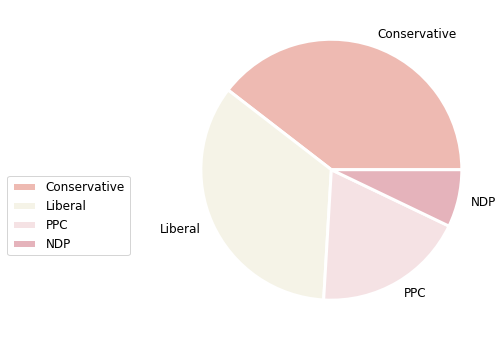

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(counts_party['Party'],labels=counts_party.index,colors=["#EEBAB2","#F5F3E7","#F5E2E4","#E5B3BB"], 
        textprops={'fontsize':12},
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.legend(counts_party.index,loc="best",bbox_to_anchor=(-0.1, 0.5),fontsize=12)
plt.show()

Two functions are designed. *party_hashtag* is used on tweets which have a true sentiment **negative**. Once the tweet contains the hashtags which clearly identify to certain parties or candidates.  
The function *party* is used on tweets with a **positive** sentiment. First, find if there is any hashtag can clearify the support for a certain party. If not, using the keywords dictionary to calculate the frequency of mentioning keywords. The corresponding political party with highest frequency will be assigned to the tweet.  

After applying the functions, a total of 478 tweets are assigned to a certain politial party.  
From the results, people who support Conservative party may be more willing to add a hashtag which clearify their stands when sending a tweet. So that is why the portion is the largest, 189. The number of Liberal is very close to Conservative, which is 165.  
Among the 478 tweets assigned with a party, the number of tweets which show support in The People's Party of Canada is 90. And New Democratic Party portion is the least, only 34 tweets show they support NDP.  

### Graphical Figure

#### Sentiment Analysis - Tweet Length & Sentiment

In [ ]:
df_sa['length'] = df_sa['text_cleaned'].apply(lambda x: len(x.split()))

In [ ]:
length_positive = df_sa.loc[df_sa['label']=='1']['length']
length_negative = df_sa.loc[df_sa['label']=='0']['length']

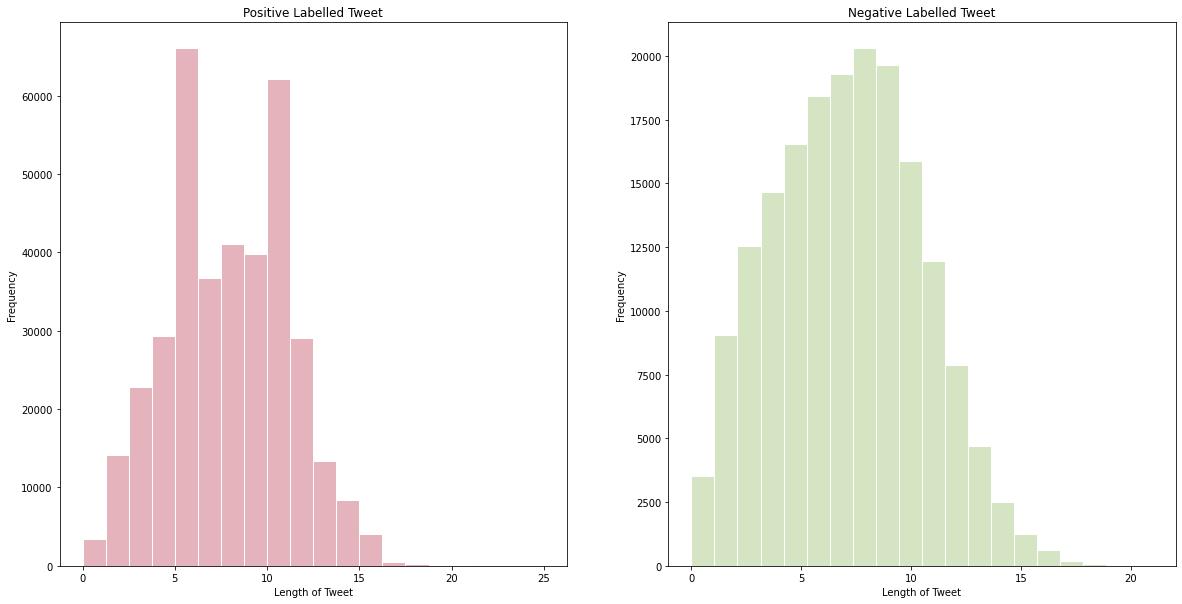

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(x=length_positive, color="#E5B3BB",bins=20,edgecolor='white')
ax[1].hist(x=length_negative, color="#D5E4C3",bins=20,edgecolor='white')
ax[0].set_xlabel("Length of Tweet")
ax[1].set_xlabel("Length of Tweet")
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")
ax[0].set_title("Positive Labelled Tweet")
ax[1].set_title("Negative Labelled Tweet")
plt.show()

From the figure, two things are observed, first, no matter the sentiment is, the tweets with length 5 words to 10 words have the highest frequency for the dataset *sentiment_analysis*. And compare to either to0 short tweets or too long tweets, when the length of the tweets are in the interval 5-10 words, the tweets are more likely to show a clear sentiment.  
And both figures are right-skewed, the negative sentiment figure are more bell-shaped and centered at length=9, while the positive sentiment figure has two significant peak at length=5 and length=10.

#### Canadian Election - Distribution of Negative Reasons

In [ ]:
reason = df_ce.groupby(['negative_reason'])['negative_reason'].count()
reason = reason.array
reason = np.delete(reason, reason.argmax())
reason_type = df_ce['negative_reason'].unique()
reason_type = np.sort(reason_type)
reason_type = np.delete(reason_type, 6)

In [ ]:
percent = reason/reason.sum()*100
percent = ["%.3f" % number for number in percent]
percent = np.array(percent)
percentage = reason_type+' '+percent+'%'

In [ ]:
color = ["#9C9359","#E7CBA9","#EEBAB2","#F5F3E7","#F5E2E4",
         "#E5B3BB","#DB93A5","#DC828F","#E4CEE0","#D5E4C3","#CCD4BF"]

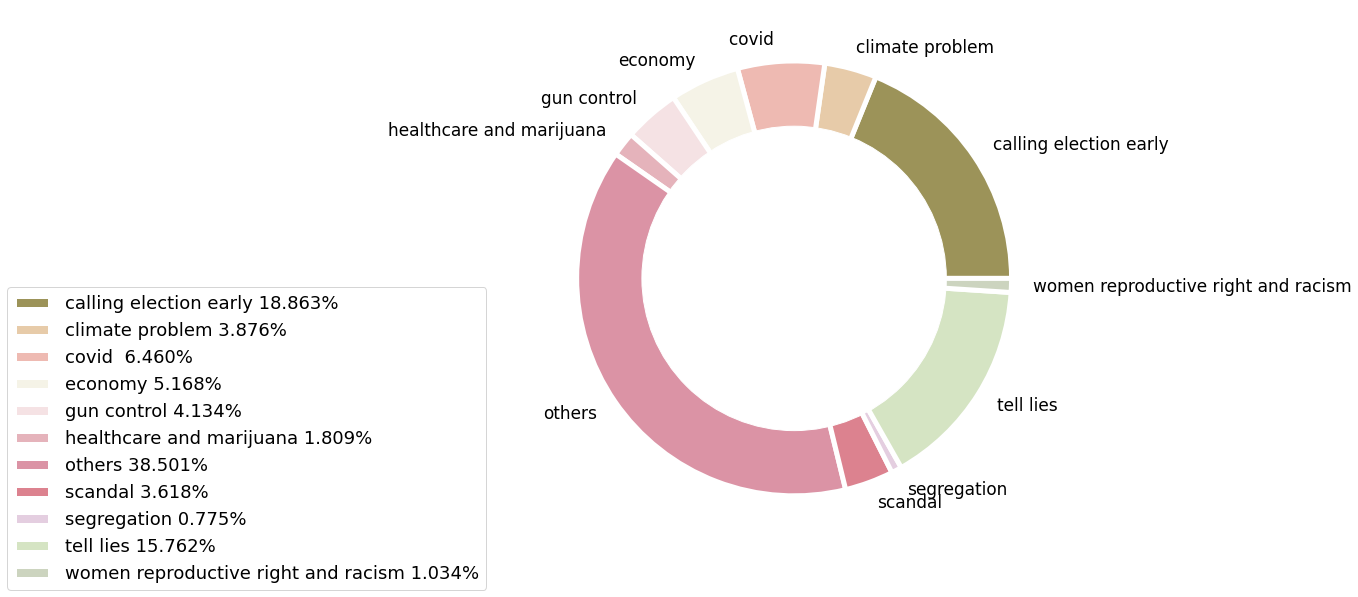

In [ ]:
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.figure(figsize=(20,10))
plt.pie(reason, labels=reason_type, colors=color, textprops={'fontsize':17},
        wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(percentage,loc="best",bbox_to_anchor=(-0.05, 0.5),fontsize=18)
plt.show()

From the dataset, there is a total of 11 negative reason classes. From the above donut plot, the reason *others* accounts for the biggest portion, 38.501%. And *calling election early* and *telling lies* follow the second and third place, the percentage is 18.863% and 15.762%, respectively. These two reasons are complaints about the candidate's personal behaviour. While the rest reasons have a similar percentage but do not account for a major position.

## 3 Sentiment Classification - Model implementationa and tuning

### a) Machine Learning Models

#### TF-IDF

In [98]:
# Spilt data
X = df_sa['text_cleaned']
y = df_sa['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [99]:
# Prepare the data using TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

#### Train seven classification algorithms

In [ ]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf,y_train)
y_pred = lr.predict(X_test_tfidf)
acc_score = accuracy_score(y_test,y_pred)
print("The accuracy score for Logistic Regression Model on test data is {:.3f}".format(acc_score))

The accuracy score for Logistic Regression Model on test data is 0.969


In [ ]:
# K-NN
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf,y_train)
y_pred_knn = knn.predict(X_test_tfidf)
acc_score_knn = accuracy_score(y_test,y_pred_knn)
print("The accuracy score for KNN Model on test data is {:.3f}".format(acc_score_knn))

The accuracy score for KNN Model on test data is 0.808


In [ ]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)
y_pred_nb = nb.predict(X_test_tfidf)
acc_score_nb = accuracy_score(y_test,y_pred_nb)
print("The accuracy score for Naive Bayes Model on test data is {:.3f}".format(acc_score_nb))

The accuracy score for Naive Bayes Model on test data is 0.933


In [ ]:
# SVM
svm = LinearSVC()
svm.fit(X_train_tfidf,y_train)
y_pred_svm = svm.predict(X_test_tfidf)
acc_score_svm = accuracy_score(y_test,y_pred_svm)
print("The accuracy score for SVM Model on test data is {:.3f}".format(acc_score_svm))

The accuracy score for SVM Model on test data is 0.970


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf,y_train)
y_pred_dt = dt.predict(X_test_tfidf)
acc_score_dt = accuracy_score(y_test,y_pred_dt)
print("The accuracy score for Decision Tree Model on test data is {:.3f}".format(acc_score_dt))

The accuracy score for Decision Tree Model on test data is 0.946


In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_pred_rf = rf.predict(X_test_tfidf)
acc_score_rf = accuracy_score(y_test,y_pred_rf)
print("The accuracy score for Random Forest Model on test data is {:.3f}".format(acc_score_rf))

The accuracy score for Random Forest Model on test data is 0.962


In [ ]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train_tfidf,y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)
acc_score_xgb = accuracy_score(y_test,y_pred_xgb)
print("The accuracy score for XGBoost Model on test data is {:.3f}".format(acc_score_xgb))

The accuracy score for XGBoost Model on test data is 0.850


In [ ]:
index = ['Logistic Regression','KNN','Naive Bayes','SVM','Decision Tree','Random Forest','XGBoost']
accuracy = [acc_score,acc_score_knn,acc_score_nb,acc_score_svm,acc_score_dt,acc_score_rf,acc_score_xgb]
accuracy = pd.DataFrame(accuracy, index=index, columns=['Test Accuracy'])

### b) Deep Learning model

#### Bag of Words

In [ ]:
# Training set (60%), Validation set (20%), Test set (20%)
X_train, X_1, y_train, y_1 = train_test_split(X, y, test_size=0.4, random_state=50)
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1, test_size=0.5, random_state=50)

In [ ]:
# Bag of Words
bag_of_words = CountVectorizer(max_features=5000)
X_train_bow = bag_of_words.fit_transform(X_train)
X_val_bow = bag_of_words.transform(X_val)
X_test_bow = bag_of_words.transform(X_test)

In [ ]:
X_train_bow = X_train_bow.toarray()

In [ ]:
X_val_bow = X_val_bow.toarray()

In [ ]:
X_test_bow = X_test_bow.toarray()

In [ ]:
y_train_float = np.array(y_train.astype('float64'))
y_val_float = np.array(y_val.astype('float64'))
y_test_float = np.array(y_test.astype('float64'))

#### Fit Deep Learning model

In [ ]:
# Define and train the deep learning model: Two fully connected hidden layer and a output layer
seed(1000)
tensorflow.random.set_seed(1234)
model = Sequential()
model.add(Dense(25, activation='sigmoid',input_dim=5000))
model.add(Dense(10, activation='sigmoid',input_dim=5000))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist = model.fit(X_train_bow,y_train_float,validation_data=(X_val_bow, y_val_float), epochs=1,batch_size=256)

1290/1290 [==============================] - 15s 11ms/step - loss: 0.2364 - accuracy: 0.9028 - val_loss: 0.0939 - val_accuracy: 0.9680


##### A function to tuning hypeparameters of the deep learning model

In [ ]:
def deep_learning_grid_search(unit, function, x_train, y_train, x_val, y_val):
  seed(1000)
  tensorflow.random.set_seed(1234)

  df = pd.DataFrame(columns=['Dense Unit', 'Activation Function', 'Accuracy', 'Loss',
                             'Validation Accuracy','Validation Loss'])
  for u in unit:
      for func in function:
        model = Sequential()
        model.add(Dense(25, activation='sigmoid',input_dim=5000))
        model.add(Dense(u,activation=func,input_dim=5000))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
      
        hist = model.fit(x_train, y_train,validation_data=(x_val, y_val), 
                          epochs=1,batch_size=256)
      
        dict1 = {'Dense Unit': u, 'Activation Function':func, 
                'Accuracy':np.around(hist.history['accuracy'],4)[0],
               'Loss':np.around(hist.history['loss'],4)[0],
                'Validation Accuracy':np.around(hist.history['val_accuracy'],4)[0],
               'Validation Loss':np.around(hist.history['val_loss'],4)[0]
               }
        df = df.append(dict1, ignore_index=True)

  return df

In [ ]:
dense_unit = [10,50,100]
activation_func = ['sigmoid','softmax','exponential']

In [ ]:
seed(1000)
tensorflow.random.set_seed(1234)
df = deep_learning_grid_search(dense_unit, activation_func, X_train_bow,y_train_float,X_val_bow, y_val_float)

1290/1290 [==============================] - 16s 12ms/step - loss: 0.1524 - accuracy: 0.9368 - val_loss: 0.0880 - val_accuracy: 0.9685


In [ ]:
df.sort_values(by=['Accuracy'],ascending=False)

,Dense Unit,Activation Function,Accuracy,Loss,Validation Accuracy,Validation Loss
2,10,exponential,0.9431,0.1402,0.9672,0.0907
8,100,exponential,0.9368,0.1524,0.9685,0.0880
5,50,exponential,0.9362,0.1566,0.9679,0.0887
0,10,sigmoid,0.9028,0.2364,0.9680,0.0939
3,50,sigmoid,0.9017,0.2230,0.9681,0.0900
6,100,sigmoid,0.8910,0.2413,0.9679,0.0911
1,10,softmax,0.8885,0.3394,0.9679,0.1724
4,50,softmax,0.8632,0.3830,0.9674,0.1847
7,100,softmax,0.8410,0.4089,0.9665,0.1855


The best performance model is when the unit of the second dense layer = 10 and the activation functio = 'exponential'

In [ ]:
# Train the best performance model on the Test Data
seed(1000)
tensorflow.random.set_seed(1234)
model_final = Sequential()
model_final.add(Dense(10, activation='sigmoid',input_dim=5000))
model_final.add(Dense(10,activation='exponential',input_dim=5000))
model_final.add(Dense(1, activation='sigmoid'))
model_final.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model_final.fit(X_train_bow,y_train_float,validation_data=(X_val_bow, y_val_float), epochs=1,batch_size=256)

1290/1290 [==============================] - 15s 11ms/step - loss: 0.1621 - accuracy: 0.9326 - val_loss: 0.0912 - val_accuracy: 0.9681


In [ ]:
scores = model_final.evaluate(X_test_bow, y_test_float)
print("The accuracy score for Deep Learning Model on test data is {:.3f}".format(scores[1]))

3440/3440 [==============================] - 10s 3ms/step - loss: 0.0948 - accuracy: 0.9677
The accuracy score for Deep Learning Model on test data is 0.968


### c) Evaluate the model with best performanace on Canada Elections data

In [ ]:
accuracy.loc['Deep Learning Model'] = scores[1]
accuracy.sort_values(by=['Test Accuracy'],ascending=False)

,Test Accuracy
SVM,0.969804
Logistic Regression,0.969404
Deep Learning Model,0.967714
Random Forest,0.962082
Decision Tree,0.945594
Naive Bayes,0.933348
XGBoost,0.850426
KNN,0.807638


The best performance model among the all models from (a) and (b) is SVM model, with highest test accuracy 0.969804

In [ ]:
# Encode the sentiment to 0 and 1
lb = LabelEncoder() 
df_ce['label'] = lb.fit_transform(df_ce['sentiment'])

In [ ]:
X_ce = df_ce['text_cleaned']
y_ce = df_ce['label'].astype('string')

In [100]:
# Apply TF-IDF on the Canadian Election data
X_tfidf = vectorizer_tfidf.transform(X_ce)

In [101]:
# svm = LinearSVC()
# svm.fit(X_train_tfidf,y_train)
y_predict = svm.predict(X_tfidf)
acc_score_ce = accuracy_score(y_ce,y_predict)
print("The accuracy score for SVM Model on Canadian Elections data is {:.3f}".format(acc_score_ce))

The accuracy score for SVM Model on Canadian Elections data is 0.750


The accuracy of the SVM model on the Canadian Election data is 75%

##### Visualize Model Results

In [ ]:
df_ce['sentiment_prediction'] = y_predict

In [126]:
predicts = list(df_ce['sentiment_prediction'].value_counts())
order = [1, 0]
predicts = [predicts[i] for i in order]
predicts

[451, 551]

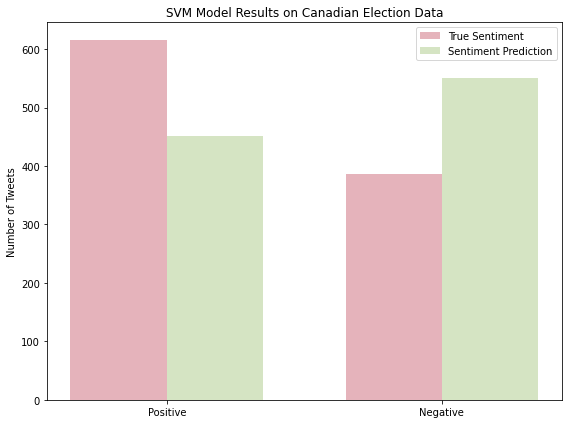

In [127]:
labels = ['Positive','Negative']

x = np.arange(len(labels)) 
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

bar1 = ax.bar(x - width/2, df_ce['label'].value_counts(),width, label='True Sentiment',color="#E5B3BB")
bar2 = ax.bar(x + width/2, predicts,width, label='Sentiment Prediction',color="#D5E4C3")
plt.title('SVM Model Results on Canadian Election Data')
plt.ylabel('Number of Tweets')
plt.xticks(x, labels)
ax.legend()

plt.tight_layout()
plt.show()

### d) Two other ecaluation metrics

In [ ]:
precision = precision_score(y_ce,y_predict, average='weighted')
print("The precision score for SVM Model on Canadian Elections data is {:.3f}".format(precision))

The precision score for SVM Model on Canadian Elections data is 0.796


In [ ]:
recall = recall_score(y_ce,y_predict, average='weighted')
print("The recall score for SVM Model on Canadian Elections data is {:.3f}".format(recall))

The recall score for SVM Model on Canadian Elections data is 0.750


Precision Score and Recall Score are chosen to evaluate the SVM model.   
Precision is the ratio between True Positives and all Positives, that can be used to see how the model correctly predicted the tweets with positive sentiment among all correct predictions.   
Recall also gives how accurately the SVM predicts the positive sentiment, which shows the ratio between correctly predicted positive tweets and the number of all true positive tweets.

### e) Visualize the sentiment prediction and true sentiment for 4 parties

In [ ]:
party_array = df_ce['Party'].unique()[1:]
true_0, true_1, predict_0, predict_1 = [], [], [], []
for party in party_array:
  true_1.append(list(df_ce[df_ce['Party']==party]['label'].value_counts())[0])
  true_0.append(list(df_ce[df_ce['Party']==party]['label'].value_counts())[1])
  predict_1.append(list(df_ce[df_ce['Party']==party]['sentiment_prediction'].value_counts())[0])
  predict_0.append(list(df_ce[df_ce['Party']==party]['sentiment_prediction'].value_counts())[1])

In [ ]:
df_party = pd.DataFrame(np.column_stack([true_0, true_1, predict_0, predict_1]),index=party_array,
             columns=['True Negative','True Positive','Predicted Negative','Predicted Positive'])

In [ ]:
df_party

,True Negative,True Positive,Predicted Negative,Predicted Positive
PPC,11,79,39,51
Liberal,11,154,63,102
Conservative,36,153,91,98
NDP,2,32,10,24


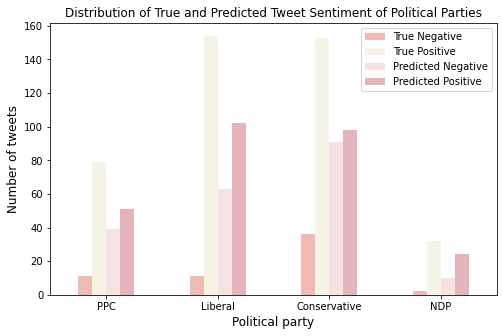

In [ ]:
df_party.plot.bar(color=["#EEBAB2","#F5F3E7","#F5E2E4","#E5B3BB"],rot=0,figsize=(8,5))
plt.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Distribution of True and Predicted Tweet Sentiment of Political Parties', fontsize=12)
plt.xlabel("Political party", fontsize=12)
plt.ylabel("Number of tweets", fontsize=12)
plt.show()

**Discuss your findings and whether NLP analytics based on tweets is useful for political parties during election campaigns**  
  
From the above figure, for all four parties, there is a big gap between the predicted results and the true sentiment. The number of predicted negative tweets is overestimated, it exceeds the number of true negative tweets, while the number of predicted positive tweets are much less than the true positive tweets.   

I think the NLP analytics is useful in election campaigns to some extent. For example, in this case, the number of against voices is overestimated, but the sense of crisis will be maintained and the party will be more cautious during the campaigns. And the general trend in predicted sentiment distribution fits the true one. However, there is still some weakness due to bias, the underestimation of positive voices of opposing parties will affect the actions and judgments. It still needs improvement.  
  
**Explain how each party is viewed in the public eye based on the sentiment value**  
  
From the result, Conservative party seems have the most support as the number of tweets about it is the most. Although Conservative party has the most negetive tweets, it still does not contradict as if the party gets more attention, against voices will also increases.  
The numbers of positive tweets of Liberal is almost 16 times with the number of negetive tweets. Thus, Liberal seems have a good reputation among people.  
In public eye, PPC is also not bad, from the graph, the number of negative tweets is around 10, while the number of positive tweets is around 80, 8 times of the negative amount. Thus, PPC may have many supporters.   
NDP attracts the least attention since the number of tweets about the party is the least.   
  
**Suggest one way you can improve the accuracy of this model**   
  
I think the hyperparameters of the model can be tuned. Because the model here is a general linear SVC model with all default parameters. If the parameters can be tuned, the model will have a higher accuracy.  
  


## 4 Negative Reason Classification

In [ ]:
# Filter the negative reasons
df_neg = df_ce.loc[df_ce['sentiment']=='negative']
negative_reason = pd.DataFrame({'Negative Reason':df_neg['negative_reason'].unique()},columns=['Negative Reason'])
# Encode the reason (11 in total)
lb = LabelEncoder() 
df_neg['negative_reason_label'] = lb.fit_transform(df_neg['negative_reason'])
negative_reason['Negative Reason Label'] = lb.fit_transform(negative_reason['Negative Reason'])
X_neg = df_neg['text_cleaned']
target = df_neg['negative_reason_label']

In [ ]:
# Split the train/test set
X_train, X_test, target_train, target_test = train_test_split(X_neg,target,test_size=0.3,random_state=50)

In [ ]:
# Use TF-IDF to prepare the data
X_reason_train = vectorizer_tfidf.transform(X_train)
X_reason_test = vectorizer_tfidf.transform(X_test)

In [ ]:
# Fit a multiclass logistic regression
lr_reason = LogisticRegression(multi_class="multinomial", random_state=50)
lr_reason.fit(X_reason_train,target_train)
target_pred = lr_reason.predict(X_reason_test)
acc_reason = accuracy_score(target_test,target_pred)
print("The accuracy score for Multiclass Logistic Regression Model on Negative Reason of Canadian Elections data is {:.3f}".format(acc_reason))

The accuracy score for Multiclass Logistic Regression Model on Negative Reason of Canadian Elections data is 0.436


In [ ]:
# Tune parameters with GridSearchCV
parameters = {'C':[0.01, 0.1, 1.0, 10.0, 100.0],
              'solver':['lbfgs', 'sag', 'saga', 'newton-cg']}
gs = GridSearchCV(lr_reason, parameters,cv=2,scoring='accuracy')
gs.fit(X_reason_train,target_train)
gs.best_params_

{'C': 10.0, 'solver': 'lbfgs'}

In [ ]:
target_pred = gs.predict(X_reason_test)
print(classification_report(target_test,target_pred))

              precision    recall  f1-score   support

           0       0.54      0.57      0.55        23
           1       1.00      0.33      0.50         3
           2       1.00      0.10      0.18        10
           3       1.00      0.12      0.22         8
           4       0.25      0.50      0.33         2
           5       0.00      0.00      0.00         3
           6       0.43      0.76      0.55        41
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1
           9       0.14      0.11      0.12        18
          10       0.00      0.00      0.00         1

    accuracy                           0.43       117
   macro avg       0.40      0.23      0.22       117
weighted avg       0.46      0.43      0.37       117



The test accuracy score for Best Performance Multiclass Logistic Regression Model on Negative Reason of Canadian Elections data is 0.43

### a) Reason why model fail to predict the correct negative reasons

In [ ]:
df_neg['negative_reason'].value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [ ]:
negative_reason

,Negative Reason,Negative Reason Label
0,calling election early,0
1,covid,2
2,others,6
3,scandal,7
4,tell lies,9
5,gun control,4
6,economy,3
7,healthcare and marijuana,5
8,segregation,8
9,women reproductive right and racism,10


In [ ]:
target = pd.DataFrame({'True Reason': target_test.to_numpy(), 
                       'Predicted Reason': target_pred}, columns=['True Reason', 'Predicted Reason'])
target.head(10)

,True Reason,Predicted Reason
0,5,9
1,6,6
2,6,0
3,3,6
4,9,6
5,6,6
6,4,4
7,6,9
8,5,9
9,6,6


I think the reason that my model fails is because the target column ['Negative Reason'] is not balanced, the number of 'others' are much more than other reasons. So from the above table, most negative reasons of tweets are predicted to be 'others'. 

### b) One Suggestion to improve the accuracy

I think that I can tune more parameters and with more tries in the grid search to get a better model. Or combined some reasons with lower numbers to one to get a more balanced data.

### c) Combine similar reasons and justify

In [ ]:
# Combine the reasons
other = ['others']
candidate_behaviour = ['calling election early','tell lies','scandal'] # Reasons due to candidates' behaviour
# Reasons about people rights or freedom
right_issue = ['gun control','women reproductive right and racism','segregation','healthcare and marijuana']
# Reasons that affect the whole country or society
society_issue = ['covid ','economy','climate problem']

In [ ]:
# Replace the reasons
df_neg['negative_reason_new'] = df_neg['negative_reason'].replace(['others','calling election early','tell lies','scandal',
                                                                   'gun control','women reproductive right and racism','segregation',
                                                                   'healthcare and marijuana', 'covid ','economy','climate problem'],
                                                                  ['other','candidate behaviour','candidate behaviour','candidate behaviour',
                                                                   'right issue','right issue','right issue',
                                                                   'right issue','society issue','society issue','society issue'])

In [ ]:
# New reason groups count
df_neg['negative_reason_new'].value_counts()

other                  149
candidate behaviour    148
society issue           60
right issue             30
Name: negative_reason_new, dtype: int64

In [ ]:
# Encode new reasons
lb = LabelEncoder() 
df_neg['negative_reason_label_new'] = lb.fit_transform(df_neg['negative_reason_new'])
X_neg = df_neg['text_cleaned']
target = df_neg['negative_reason_label_new']

In [ ]:
# Split training/test set
X_train, X_test, target_train, target_test = train_test_split(X_neg,target,test_size=0.3,random_state=50)

In [ ]:
# Apply Bag-of-Words
X_reason_train = bag_of_words.transform(X_train)
X_reason_test = bag_of_words.transform(X_test)

In [ ]:
# Apply TF-IDF
X_reason_train_tf = vectorizer_tfidf.transform(X_train)
X_reason_test_tf = vectorizer_tfidf.transform(X_test)

In [ ]:
# Train model and Tuning Hyperparameters (BOW)
lr_reason = LogisticRegression(multi_class="multinomial", random_state=50)
parameters = {'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'solver':['lbfgs', 'sag', 'saga', 'newton-cg'],
              'class_weight':[None,'balanced'],
              'penalty':['l1', 'l2', 'elasticnet', 'none']}
gs = GridSearchCV(lr_reason, parameters,cv=2,scoring='accuracy')
gs.fit(X_reason_train,target_train)
gs.best_params_

{'C': 1.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
target_pred = gs.predict(X_reason_test)
acc_reason = accuracy_score(target_test,target_pred)
print("The accuracy score for Multiclass Logistic Regression on Negative Reason of Canadian Elections data is {:.3f}".format(acc_reason))

The accuracy score for Multiclass Logistic Regression on Negative Reason of Canadian Elections data is 0.504


In [ ]:
# Train model and Tuning Hyperparameters (TF-IDF)
lr_reason = LogisticRegression(multi_class="multinomial", random_state=50)
parameters = {'C':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'solver':['lbfgs', 'sag', 'saga', 'newton-cg'],
              'class_weight':[None,'balanced'],
              'penalty':['l1', 'l2', 'elasticnet', 'none']}
gs = GridSearchCV(lr_reason, parameters,cv=2,scoring='accuracy')
gs.fit(X_reason_train_tf,target_train)
gs.best_params_

{'C': 0.001, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs'}

In [ ]:
target_pred = gs.predict(X_reason_test_tf)
acc_reason = accuracy_score(target_test,target_pred)
print("The accuracy score for Multiclass Logistic Regression on Negative Reason of Canadian Elections data is {:.3f}".format(acc_reason))

The accuracy score for Multiclass Logistic Regression on Negative Reason of Canadian Elections data is 0.513


After combining the reasons, the new model with best performance after tuning has a test accuracy on Negative Reason of Canadian Elections data is 0.513. For this model, using TF-IDF to prepare the data.